# DataLab Cup 3: Image Caption

Team name: 卍閃傲o剎帝卍

Team members:

    106024510 陳俊穎 Chen, Chun Ying

    106024513 曾奕齊 Tseng, Yi-Chi

    106024519 吳亦振 Wu, Yi-Chen

    106024509 曾立豪 Zeng, Li Hao

Your report should include:

- Student ID, name of each team member.

- Your code and some descriptions.

- How did you preprocess your data (if you did it by yourself, not using the method on course notebook)

- Do you use pre-trained model ? (word embedding model, CNN model, etc.) 

- How do you design your image captioning model? (illustrate every step you design and why this works)

- Any tricks or techniques you used in this task.

- Demo: take arbitrary one image and use your model to generate caption for it in your report.

- Conclusions (interesting findings, pitfalls, takeaway lessons, etc.)

#### Referece : Github ( Hvass-Labs )

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb

### 1. Data preprocessing of  image and captions

The precessing method of captions and images are from the course notebook, except we did not use 'tfrecords' to save data. 

In [2]:
'''

Preprocessing of captions :

1. Transfer rare vocabularies (frequency < 30) to 'unk'.
2. Add '<PAD>' 、 start word '<ST>' and end word '<ED>' to vocaulary list then build encode map and decode map. 

'''

enc_map = cPickle.load(open('enc_map.pkl', 'rb'))
dec_map = cPickle.load(open('dec_map.pkl', 'rb'))

'''

Preprocessing of images :

We use 'train_img256.pkl' and 'test_img256.pkl' as image feature

'''

train_data = pd.read_csv('train.csv')

filenames_train = pd.unique(train_data.img_id) 

img_train = cPickle.load(open('train_img256.pkl', 'rb'))


img_test = cPickle.load(open('test_img256.pkl', 'rb'))


test_id = list(pd.read_csv('test.csv').img_id)


In [3]:
## Create nested list of train image feature.

transfer_values_train = np.zeros((len(filenames_train), 256), dtype = np.float16)

j = 0

for id in filenames_train :
    
    transfer_values_train[j] = img_train[id]

    j += 1

    
## Create nested list of test image feature.
    
transfer_values_test = np.zeros((len(img_test), 256), dtype = np.float16)
    
j = 0

for id in list(test_id) :
    
    transfer_values_test[j] = img_test[id]

    j += 1

    

## Create nested list of train image captions. 

captions_train = []

gb = train_data.groupby('img_id')

j = 1

for id in filenames_train:
    
    captions_train.append(list(gb.get_group(id).iloc[:, 1]))
    
    if j % 10000 == 0 :
        
        print('%.1f 趴 has done !'%(j / len(filenames_train) * 100))
        
    j += 1    

9.7 趴 has done !
19.5 趴 has done !
29.2 趴 has done !
38.9 趴 has done !
48.7 趴 has done !
58.4 趴 has done !
68.1 趴 has done !
77.9 趴 has done !
87.6 趴 has done !
97.3 趴 has done !


In [4]:
## Add start word and end word to train captions 


def add_start_end(captions, start = '<ST>', end = '<ED>'):
    
    res = []
    
    for i in range(0, len(captions)):
        
        sen = []
        
        for j in range(0, len(captions[i])):
            
            
            sen.append('%s '%(start) + captions[i][j] + ' %s'%(end))
            
        res.append(sen)
    
        
    return res       
    
captions_train_add = add_start_end(captions_train)


## Tokenized 


def voc_to_int(sent, voc_int):
    
    sentence = sent.split(' ')
    
    for i in range(0, len(sentence)) :
        
        sentence[i] = voc_int[sentence[i]]
    
    return sentence


def token_list(cap_list, voc_int) :
    
    res = []
    
    for i in range(0, len(cap_list)) :
        
        gg = []
        
        for j in range(0, len(cap_list[i])) :
            
            gg.append(voc_to_int(cap_list[i][j], voc_int))
    
        res.append(gg)
    
    return res


tokens_train = token_list(captions_train_add, enc_map)


We use pretrained word embedding model 'glove.6B.200d.txt' then create embedding matrix.

In [5]:
def generate_embedding_matrix(w2v_path, dec_map, lang_dim=200):
    
    embeddings_index = {}
    
    f = open(w2v_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    embedding_matrix = np.random.rand(len(dec_map), lang_dim)    
    
    for i in range(3, len(dec_map)) : # First three vocabs are '<PAD>'、'<ST>' and '<ED>', we assigned with random vector.    
        
        embedding_matrix[i] = embeddings_index['unk']  # Assign vector to unknown and rare words
           
    for idx, wd in dec_map.items():
        
        if wd in embeddings_index.keys():
            
            embedding_matrix[idx] = embeddings_index[wd]


    return embedding_matrix


embedding_matrix = generate_embedding_matrix('glove.6B.200d.txt', dec_map)

### Create  batch data generator

In [6]:
def batch_generator(batch_size):
    
    from itertools import chain
    
    import random
    
    while True :  # Infinite loop for next epoch.
    
        big_train_values = np.zeros((train_data.shape[0], 256), dtype = np.float16)

        k = 0  
          
        for i in range(0, len(captions_train)) :
            
            for j in range(0, len(captions_train[i])) :
                
                big_train_values[k] = transfer_values_train[i]
                
                k += 1
        
        big_train_tokens = list(chain(*tokens_train))
                    
        r = np.random.choice(train_data.shape[0], train_data.shape[0], replace = False)
        
        big_train_values = big_train_values[r]
        
        
        nnn = []
        
        for jj in r :
            
            nnn.append(big_train_tokens[jj])
        
        big_train_tokens = nnn
        
        gg = len(big_train_tokens) // batch_size
        
        
        for j in range(0, gg) :
                   
            transfer_values = big_train_values[(batch_size * j) : (batch_size * j + batch_size)]
            
            tokens = big_train_tokens[(batch_size * j) : (batch_size * j + batch_size)]
               
            num_tokens = [len(t) for t in tokens]
            
            max_tokens = np.max(num_tokens)
            
            tokens_padded = pad_sequences(tokens,
                                  maxlen=max_tokens,
                                  padding='post',
                                  truncating='post')
            
            
            decoder_input_data = tokens_padded[:, 0:-1]
            decoder_output_data = tokens_padded[:, 1:]
    
            x_data = \
            {
                'decoder_input': decoder_input_data,
                'transfer_values_input': transfer_values
            }
    
            y_data = \
            {
                'decoder_output': decoder_output_data
            }
            
            yield (x_data, y_data)
            
            
        transfer_values = big_train_values[(batch_size * gg) : ]
            
        tokens = big_train_tokens[(batch_size * gg) : ]
           
        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = pad_sequences(tokens,
                              maxlen=max_tokens,
                              padding='post',
                              truncating='post')
        
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]
    
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }
    
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

### Image caption model

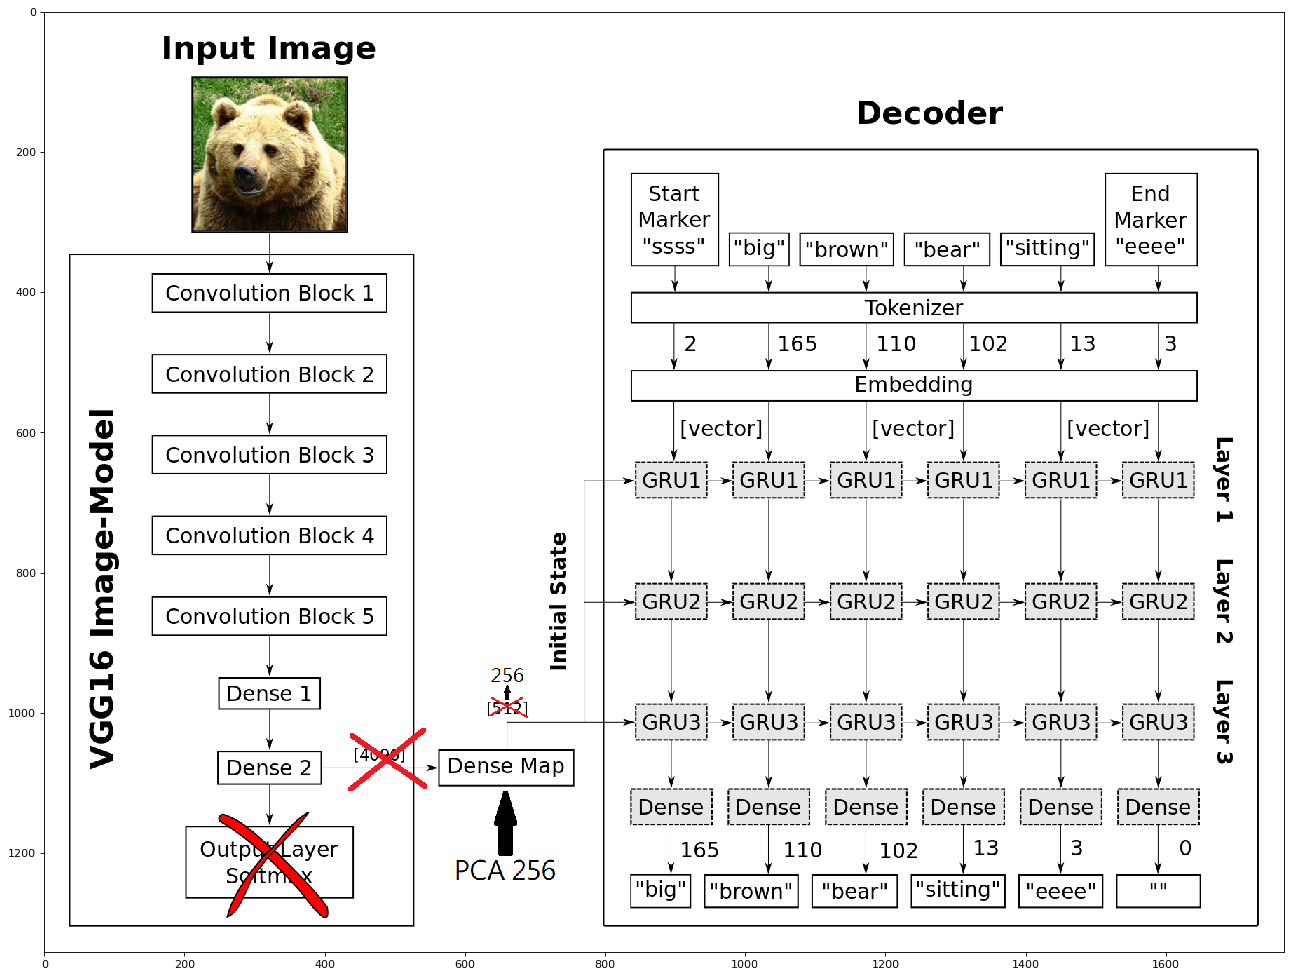

In [31]:
from matplotlib.pyplot import figure
img = Image.open('adjust flow chart.png')
figure(num=None, figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img)

In [7]:
batch_size = 256
generator = batch_generator(batch_size=batch_size)

In [8]:
steps_per_epoch = int(np.ceil(train_data.shape[0]/batch_size))

In [9]:
state_size = 256

embedding_size = 200


## Feed pca 256 features vector 

transfer_values_input = Input(shape=(256,), name='transfer_values_input')  

## Dense features to 256 dim, let the value between [-1, 1] and become initial state. 

decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')


## decoder inputs : captoins

decoder_input = Input(shape=(None, ), name='decoder_input')

## use pretrained embedding vector

num_words = len(dec_map)

decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              weights=[embedding_matrix],
                              trainable=True,
                              name='decoder_embedding')

## build 3 layer GRU

decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

## decoder output

decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')


## connect encoder and decoder

def connect_decoder(transfer_values):
      
    initial_state = decoder_transfer_map(transfer_values)
   
    net = decoder_input
    
    net = decoder_embedding(net)
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    decoder_output = decoder_dense(net)
    
    return decoder_output


decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output]) 

In [10]:
## define loss function

def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean


## we choose Adam optimizer

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=optimizer, loss=sparse_cross_entropy, target_tensors=[decoder_target])

## save weight per epoch

path_checkpoint = 'weights_pca_glove.{epoch:02d}.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)



callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)


callbacks = [callback_checkpoint, callback_tensorboard]

Start training (skip)

In [ ]:
os.chdir('D:/DL')

start = time.time()

decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=30,
                            callbacks=callbacks)

end = time.time()
print("Running Time : %d min %d sec"%(math.floor((end - start) / 60),math.ceil((end - start) % 60 )))

Load weight and predict caption of test image

In [11]:
os.chdir('D:/DL')

decoder_model.load_weights('weights_pca_glove.30.keras')

def generate_caption(transfer_values, max_tokens=20):

    transfer_values = transfer_values.reshape(1, 256)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    
    token_start = enc_map['<ST>']

    token_end = enc_map['<ED>']

    token_int = token_start


    output_text = ''

    count_tokens = 0


    while token_int != token_end and count_tokens < max_tokens:

        decoder_input_data[0, count_tokens] = token_int


        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        decoder_output = decoder_model.predict(x_data)


        token_onehot = decoder_output[0, count_tokens, :]


        token_int = np.argmax(token_onehot)


        sampled_word = dec_map[token_int]


        output_text += " " + sampled_word


        count_tokens += 1


    output_tokens = decoder_input_data[0]

    return ' '.join(output_text.split(' ')[1:-1])


### Demo

In [12]:
test_img = list(pd.read_csv('test.csv').img_id)

In [13]:
def demo_image_and_caption(img_path) :
    
    img = cv2.imread('test image/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    
    print(' Prediction caption :')
    print(generate_caption(transfer_values_test[test_img.index(img_path)]))

 Prediction caption :
a man in a wet suit riding a surfboard on a wave


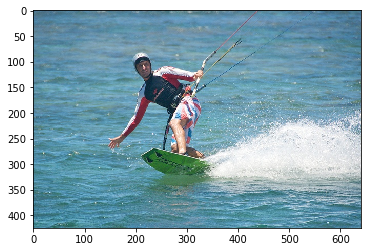

In [15]:
demo_image_and_caption(test_img[0])

 Prediction caption :
two men sitting at a table with a cake


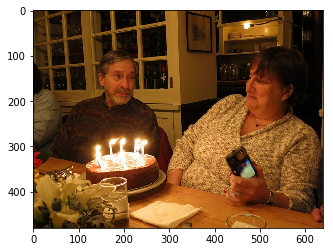

In [16]:
demo_image_and_caption(test_img[1])

 Prediction caption :
a traffic light sitting on the side of a road


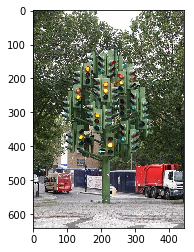

In [17]:
demo_image_and_caption(test_img[2])

 Prediction caption :
a street sign with a street sign above it


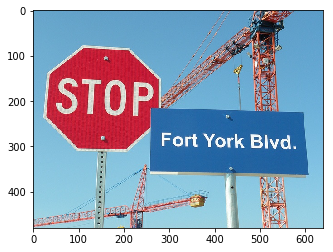

In [18]:
demo_image_and_caption(test_img[3])

 Prediction caption :
a computer desk with a keyboard and a monitor


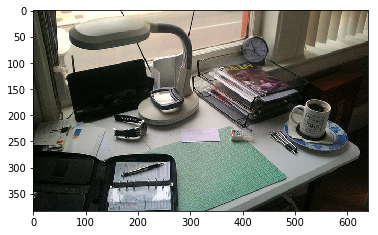

In [19]:
demo_image_and_caption(test_img[4])

### Experiment

During this competition we did serveral experiments on our baseline model using GRU and dense layer while feeding image features as initial statet.However, since it took so long to run on our own computers, we decided to track loss for 5~10 epochs and determine whether we keep the change or not. The list of our experiments is as below:
1. Using a layer of GRU or three layers of GRU, we choose to keep three layers of GRU at the end.
2. Adding pretrained word vector grom google glove, it worked and we decided to keep.
3. Feeding features to every step instead of the first, it does not work and we decided not to keep the change.
4. Beam search, out didn't improve our score which seems strange, but it might be us implementing it wrong.
5. Gradient clipping to (0,1), it doesn't improve our loss.
6. Tuning initial learning rate, the better one is our final learning rate for model.
7. Using PCA features of compressed (using autoencoder) features from the 1024 dense layer, Using PCA features seems to have better results.
8. Changing learning rate to be 1/10 of original learning rate after some epochs when loss started to stuck, it worked and improved our score significantly, however when we finish running the script the competition has already ended, resulted in late submission.

### Conclusion

We learned a lot during this competition. It is designed well to be challenging but not desperate for us. Trying serveral hints and researching, we did some good changes to our initial model and we finally scored above benchmark 80, which is a satisfying result to us. Image captioning is fun and watching our model gradually improving made us feel good. However, after the winner sharing we felt that there are many other things we can try to reacher a way higher score than our best result, and we wish to learn this lesson and apply it on the next reversed image captioning competition.